In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.cpu_count())

12


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
from collections import Counter
import shutil

In [4]:
# Paths
base_dir = '/content/drive/MyDrive/Colab_Notebooks/CVDL/Project/Dataset'
local_dir = '/content/local_dataset'  # For faster local copy
if not os.path.exists(local_dir):
    shutil.copytree(base_dir, local_dir)
train_dir = os.path.join(local_dir, 'Train')
test_dir = os.path.join(local_dir, 'Test')

# Hyperparameters
batch_size = 64
num_epochs = 20
learning_rate = 0.001
num_classes = 8  # AffectNet emotions

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class names (adjust if not matching your folders)
class_names = sorted(os.listdir(train_dir))  # e.g., ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print(f"Classes: {class_names}")

Using device: cuda
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# Enhanced transforms for training (more augmentation for robustness)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with test_transform initially for both (no augmentation)
train_dataset = datasets.ImageFolder(train_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Combine and split datasets
total_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
total_size = len(total_dataset)
train_size = int(0.7 * total_size)
test_size = total_size - train_size

# Perform random split with a fixed seed for reproducibility
train_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Apply train transforms to both underlying datasets for the train split
train_dataset.dataset.datasets[0].transform = train_transform
train_dataset.dataset.datasets[1].transform = train_transform
# Test split keeps test_transform

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 21438, Test samples: 9188


In [6]:
# Load pretrained EfficientNet-B4
model = models.efficientnet_b4(pretrained=True)

# Modify the classifier for 8 classes with dropout
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final classifier and the last two feature blocks (features[7], [8])
for param in model.classifier.parameters():
    param.requires_grad = True
for param in model.features[8].parameters():  # Final block
    param.requires_grad = True
for param in model.features[7].parameters():  # Penultimate block
    param.requires_grad = True

# Move to device
model = model.to(device)

# Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=1e-4
)

print("Model ready for training.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 216MB/s]


Model ready for training.


In [7]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} Train'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1} Val'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(test_loader)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        print(f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

        # Save best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/CVDL/Project/Dataset/efficientnet_b4_Tuned2_best.pth')

    return train_losses, train_accs, val_losses, val_accs

# Run training
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch 1 Train: 100%|██████████| 335/335 [00:59<00:00,  5.67it/s]


Epoch 1/20 - Train Loss: 1.3718, Acc: 0.4636


Epoch 1 Val: 100%|██████████| 144/144 [00:21<00:00,  6.65it/s]


Val Loss: 1.1825, Acc: 0.5394


Epoch 2 Train: 100%|██████████| 335/335 [00:57<00:00,  5.78it/s]


Epoch 2/20 - Train Loss: 1.1876, Acc: 0.5440


Epoch 2 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.1256, Acc: 0.5686


Epoch 3 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 3/20 - Train Loss: 1.1168, Acc: 0.5725


Epoch 3 Val: 100%|██████████| 144/144 [00:21<00:00,  6.64it/s]


Val Loss: 1.0935, Acc: 0.5812


Epoch 4 Train: 100%|██████████| 335/335 [00:57<00:00,  5.78it/s]


Epoch 4/20 - Train Loss: 1.0694, Acc: 0.5914


Epoch 4 Val: 100%|██████████| 144/144 [00:21<00:00,  6.64it/s]


Val Loss: 1.0658, Acc: 0.5919


Epoch 5 Train: 100%|██████████| 335/335 [00:57<00:00,  5.78it/s]


Epoch 5/20 - Train Loss: 1.0351, Acc: 0.6078


Epoch 5 Val: 100%|██████████| 144/144 [00:21<00:00,  6.65it/s]


Val Loss: 1.0469, Acc: 0.6072


Epoch 6 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 6/20 - Train Loss: 1.0141, Acc: 0.6143


Epoch 6 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.0521, Acc: 0.6042


Epoch 7 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 7/20 - Train Loss: 0.9909, Acc: 0.6260


Epoch 7 Val: 100%|██████████| 144/144 [00:21<00:00,  6.64it/s]


Val Loss: 1.0392, Acc: 0.6095


Epoch 8 Train: 100%|██████████| 335/335 [00:58<00:00,  5.78it/s]


Epoch 8/20 - Train Loss: 0.9627, Acc: 0.6337


Epoch 8 Val: 100%|██████████| 144/144 [00:21<00:00,  6.64it/s]


Val Loss: 1.0259, Acc: 0.6161


Epoch 9 Train: 100%|██████████| 335/335 [00:57<00:00,  5.78it/s]


Epoch 9/20 - Train Loss: 0.9382, Acc: 0.6519


Epoch 9 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.0080, Acc: 0.6178


Epoch 10 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 10/20 - Train Loss: 0.9191, Acc: 0.6568


Epoch 10 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.0173, Acc: 0.6209


Epoch 11 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 11/20 - Train Loss: 0.9073, Acc: 0.6566


Epoch 11 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.0197, Acc: 0.6246


Epoch 12 Train: 100%|██████████| 335/335 [00:57<00:00,  5.78it/s]


Epoch 12/20 - Train Loss: 0.8847, Acc: 0.6697


Epoch 12 Val: 100%|██████████| 144/144 [00:21<00:00,  6.65it/s]


Val Loss: 1.0275, Acc: 0.6258


Epoch 13 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 13/20 - Train Loss: 0.8692, Acc: 0.6796


Epoch 13 Val: 100%|██████████| 144/144 [00:21<00:00,  6.64it/s]


Val Loss: 1.0241, Acc: 0.6216


Epoch 14 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 14/20 - Train Loss: 0.8563, Acc: 0.6839


Epoch 14 Val: 100%|██████████| 144/144 [00:21<00:00,  6.61it/s]


Val Loss: 1.0544, Acc: 0.6217


Epoch 15 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 15/20 - Train Loss: 0.8285, Acc: 0.6916


Epoch 15 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.0258, Acc: 0.6224


Epoch 16 Train: 100%|██████████| 335/335 [00:57<00:00,  5.78it/s]


Epoch 16/20 - Train Loss: 0.8170, Acc: 0.6994


Epoch 16 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.0455, Acc: 0.6178


Epoch 17 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 17/20 - Train Loss: 0.8080, Acc: 0.7033


Epoch 17 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]


Val Loss: 1.0396, Acc: 0.6144


Epoch 18 Train: 100%|██████████| 335/335 [00:58<00:00,  5.77it/s]


Epoch 18/20 - Train Loss: 0.7939, Acc: 0.7065


Epoch 18 Val: 100%|██████████| 144/144 [00:21<00:00,  6.62it/s]


Val Loss: 1.0224, Acc: 0.6327


Epoch 19 Train: 100%|██████████| 335/335 [00:58<00:00,  5.76it/s]


Epoch 19/20 - Train Loss: 0.7821, Acc: 0.7121


Epoch 19 Val: 100%|██████████| 144/144 [00:21<00:00,  6.62it/s]


Val Loss: 1.0416, Acc: 0.6273


Epoch 20 Train: 100%|██████████| 335/335 [00:57<00:00,  5.78it/s]


Epoch 20/20 - Train Loss: 0.7579, Acc: 0.7239


Epoch 20 Val: 100%|██████████| 144/144 [00:21<00:00,  6.63it/s]

Val Loss: 1.0580, Acc: 0.6284


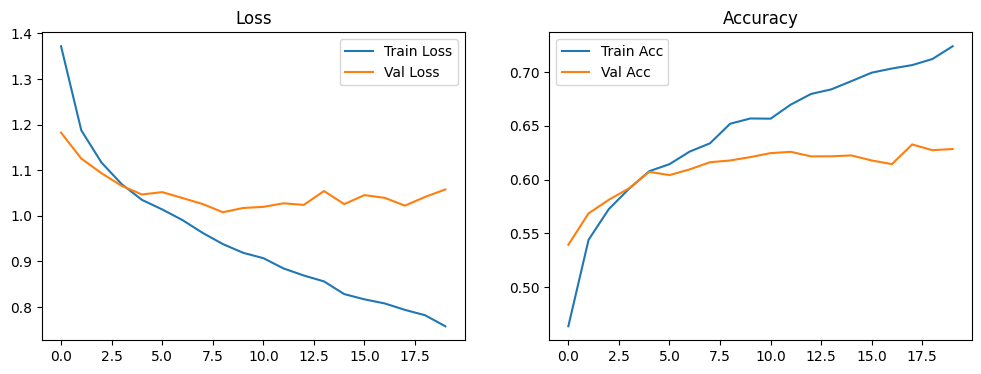

In [8]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

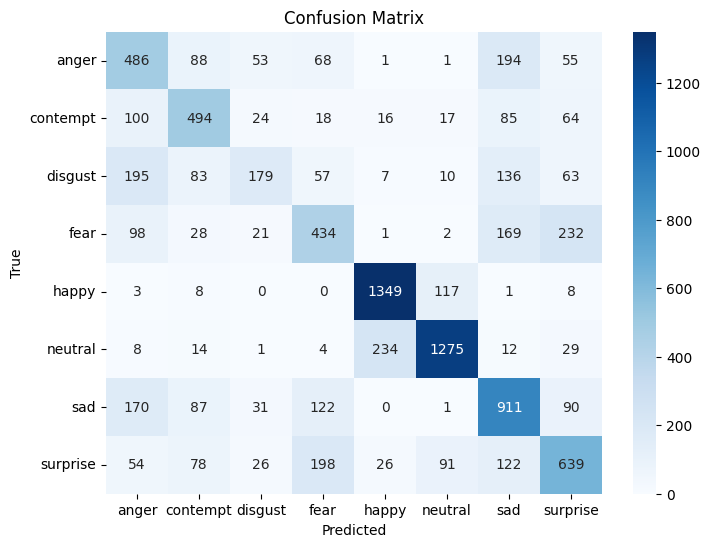

              precision    recall  f1-score   support

       anger       0.44      0.51      0.47       946
    contempt       0.56      0.60      0.58       818
     disgust       0.53      0.25      0.34       730
        fear       0.48      0.44      0.46       985
       happy       0.83      0.91      0.86      1486
     neutral       0.84      0.81      0.82      1577
         sad       0.56      0.65      0.60      1412
    surprise       0.54      0.52      0.53      1234

    accuracy                           0.63      9188
   macro avg       0.60      0.59      0.58      9188
weighted avg       0.63      0.63      0.62      9188



In [9]:
# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/CVDL/Project/Dataset/efficientnet_b4_Tuned2_best.pth'))
model.eval()

# Predictions
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report (accuracy, precision, recall)
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Inference function
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        confidence = torch.nn.functional.softmax(output, dim=1)[0][predicted].item()
    return class_names[predicted.item()], confidence

# Example: Upload or use Drive path
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # First uploaded file
# Or: image_path = '/content/drive/MyDrive/path/to/your/test_image.jpg'

emotion, conf = predict_image(image_path)
print(f"Predicted: {emotion} with confidence {conf:.2f}")

Predicted: happy with confidence 1.00
